In [2]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import os, re 
from collections import Counter

#  <font color = teal> Sinus Rhythm analysis for the data sets of Physionet Challenge 2021 and Shandong Provincial Hospital </font>

The purpose for this notebook is to analyse the sinus rhythm (SR) label occuring in the [Physionet Challenge 2021 data](https://moody-challenge.physionet.org/2021/). <font color = teal> <b>Logistic regression model</b></font> is trained using the Physionet metadata, and then used to imputate the SR labels into the [Shandong Provincial Hospital (SPH) dataset by Hui et al 2022](https://www.nature.com/articles/s41597-022-01403-5#code-availability) which doesn't have them yet. The reason for this is that we need the SR labels to compute the physionet challenge score defined for the Physionet Challenge 2021.

------------------

# <font color = teal>Physionet Challenge 2021 data </font>


In [3]:
import os

input_dir = '../data/physionet_data/'
header_files = [] # paths of the header files

for root, dirs, files in os.walk(input_dir):
    print(f"Opening the root {root}...")
    
    if 'INCART' in root:
         continue
    
    for file in sorted(files):
        if not file.lower().startswith('.') and file.lower().endswith('hea'):
                g = os.path.join(root, file)
                header_files.append(g)
                
print()
print("Found for example")
print(*header_files[0:5], sep="\n")

Opening the root ../data/physionet_data/...
Opening the root ../data/physionet_data/CPSC_CPSC-Extra...
Opening the root ../data/physionet_data/ChapmanShaoxing_Ningbo...
Opening the root ../data/physionet_data/PTB_PTBXL...
Opening the root ../data/physionet_data/INCART...
Opening the root ../data/physionet_data/G12EC...

Found for example
../data/physionet_data/CPSC_CPSC-Extra/A0001.hea
../data/physionet_data/CPSC_CPSC-Extra/A0002.hea
../data/physionet_data/CPSC_CPSC-Extra/A0003.hea
../data/physionet_data/CPSC_CPSC-Extra/A0004.hea
../data/physionet_data/CPSC_CPSC-Extra/A0005.hea


In [4]:
def get_information(filenames):
    '''
        Extracting the patient information
    param: 
        str():filenames - header files (.hea)
    returns:
        pd.dataFrame():pandas DataFrame of patient data
    '''
    result_df = pd.DataFrame()
    for filename in filenames:
        with open(filename, 'r') as f:
            f_name = re.search(r'\w*.\d\w.hea', filename).group()
            dxs = []; age = ""; gender = ""; rx = ""; hx = "Unknown"; sx = "Unknown"
            for line in f:
                
                # Get information needed
                if line.startswith('#Dx'):
                    dxs = line.split(': ')[1].split(',')
                    dxs = [dx.strip() for dx in dxs]
                if line.startswith('#Age'):
                    age = line.split(': ')[1].strip()
                if line.startswith('#Sex'):
                    gender = line.split(': ')[1].strip() 
                if line.startswith('#Rx'):
                    rx = line.split(': ')[1].strip()
                if line.startswith('#Hx'):
                    hx = line.split(': ')[1].strip()
                if line.startswith('#Sx'):
                    sx = line.split(': ')[1].strip()

            # Gathering the patient information into dictionary for dataframe
            info = pd.DataFrame({'Age': age,
                    'Gender': gender,
                    'Diagnosis': [dxs],
                    'Prescription': rx,
                    'History': hx,
                    'Symptom or surgery': sx,
                    'file': f_name})
            result_df = pd.concat([result_df, info], ignore_index=True, axis=0)
    
    return result_df

In [5]:
df = get_information(header_files)
print(f"The length of the data frame: {len(df)}")
print()
display(df.info())
print("The 10 first rows:")
display(df.head(10))

The length of the data frame: 88179

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88179 entries, 0 to 88178
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Age                 88179 non-null  object
 1   Gender              88179 non-null  object
 2   Diagnosis           88179 non-null  object
 3   Prescription        88179 non-null  object
 4   History             88179 non-null  object
 5   Symptom or surgery  88179 non-null  object
 6   file                88179 non-null  object
dtypes: object(7)
memory usage: 4.7+ MB


None

The 10 first rows:


,Age,Gender,Diagnosis,Prescription,History,Symptom or surgery,file
0,74,Male,[59118001],Unknown,Unknown,Unknown,A0001.hea
1,49,Female,[426783006],Unknown,Unknown,Unknown,A0002.hea
2,81,Female,[164889003],Unknown,Unknown,Unknown,A0003.hea
3,45,Male,[164889003],Unknown,Unknown,Unknown,A0004.hea
4,53,Male,[164884008],Unknown,Unknown,Unknown,A0005.hea
5,29,Male,[59118001],Unknown,Unknown,Unknown,A0006.hea
6,74,Male,[164889003],Unknown,Unknown,Unknown,A0007.hea
7,80,Female,[429622005],Unknown,Unknown,Unknown,A0008.hea
8,81,Male,[164889003],Unknown,Unknown,Unknown,A0009.hea
9,82,Male,[59118001],Unknown,Unknown,Unknown,A0010.hea


In [6]:
# Let's have a backup so no need to load everything everytime when messing up with the original one......
df_backup = df.copy(deep=True)

#df = df_backup.copy()

In [7]:
# Drop INCART
incart_idx = [i for i, file in enumerate(df['file']) if 'I' in file]
#df = df.drop(incart_idx)
incart_idx = [i for i, file in enumerate(df['file']) if 'I' in file]
incart_idx

[]

# <font color = teal> Merging labels </font>

There are some labels that we want to merge into one bigger parent label. For example, for this analysis, "prolonged PR interval" will be merged into "1st degree heart block".

In [8]:
# We want to merge all "prolonged pr interval" to "1st degree heart block" (Physionet mapping)
prolonged_pr_snomed = 164947007
first_degree_hb_snomed = 270492004

# Let's find all prolonged pr intervals
pr_idx = [i for i, row in df.iterrows() if prolonged_pr_snomed in list(map(int, row['Diagnosis']))]

display(df.loc[pr_idx, :].head())

# How many of these have both diagnosis?
both_idx = [i for i, row in df.loc[pr_idx, :].iterrows() if first_degree_hb_snomed in list(map(int, row['Diagnosis']))]

display(df.loc[both_idx, :].head())

print(f'Out of {len(pr_idx)} patients that have prolonged PR, {len(both_idx)} also have 1st degree hb diagnosed.')

,Age,Gender,Diagnosis,Prescription,History,Symptom or surgery,file
10614,72,Female,"[426177001, 164947007]",Unknown,Unknown,Unknown,JS00295.hea
11415,54,Male,"[426177001, 164947007]",Unknown,Unknown,Unknown,JS01141.hea
11880,51,Female,"[426177001, 164947007]",Unknown,Unknown,Unknown,JS01617.hea
13256,27,Male,"[427084000, 164947007, 428750005, 59931005]",Unknown,Unknown,Unknown,JS03057.hea
14300,66,Male,"[427084000, 39732003, 164947007]",Unknown,Unknown,Unknown,JS04155.hea


,Age,Gender,Diagnosis,Prescription,History,Symptom or surgery,file
55828,75,Male,"[164861001, 164873001, 164890007, 164947007, 2...",Unknown,Unknown,Unknown,HR00347.hea
55894,85,Male,"[164861001, 164884008, 164934002, 164947007, 2...",Unknown,Unknown,Unknown,HR00413.hea
56148,84,Male,"[164947007, 270492004, 426783006, 713426002, 8...",Unknown,Unknown,Unknown,HR00667.hea
56166,85,Male,"[164865005, 164947007, 251120003, 270492004, 4...",Unknown,Unknown,Unknown,HR00685.hea
56169,85,Male,"[164861001, 164947007, 270492004, 426783006, 6...",Unknown,Unknown,Unknown,HR00688.hea


Out of 392 patients that have prolonged PR, 125 also have 1st degree hb diagnosed.


In [9]:
# Find patients that lack wanted diagnosis
merge_idx = [dx for dx in pr_idx if not dx in both_idx]
print('This many need the 1st degree hb diagnosis:', len(merge_idx))

merge_df = df.copy().loc[merge_idx, :]
display(merge_df.head())

This many need the 1st degree hb diagnosis: 267


,Age,Gender,Diagnosis,Prescription,History,Symptom or surgery,file
10614,72,Female,"[426177001, 164947007]",Unknown,Unknown,Unknown,JS00295.hea
11415,54,Male,"[426177001, 164947007]",Unknown,Unknown,Unknown,JS01141.hea
11880,51,Female,"[426177001, 164947007]",Unknown,Unknown,Unknown,JS01617.hea
13256,27,Male,"[427084000, 164947007, 428750005, 59931005]",Unknown,Unknown,Unknown,JS03057.hea
14300,66,Male,"[427084000, 39732003, 164947007]",Unknown,Unknown,Unknown,JS04155.hea


In [10]:
# Append "1st degree heart block" to all patients
for dx in merge_df['Diagnosis']:
    dx.append(str(first_degree_hb_snomed))

display(merge_df.head())

,Age,Gender,Diagnosis,Prescription,History,Symptom or surgery,file
10614,72,Female,"[426177001, 164947007, 270492004]",Unknown,Unknown,Unknown,JS00295.hea
11415,54,Male,"[426177001, 164947007, 270492004]",Unknown,Unknown,Unknown,JS01141.hea
11880,51,Female,"[426177001, 164947007, 270492004]",Unknown,Unknown,Unknown,JS01617.hea
13256,27,Male,"[427084000, 164947007, 428750005, 59931005, 27...",Unknown,Unknown,Unknown,JS03057.hea
14300,66,Male,"[427084000, 39732003, 164947007, 270492004]",Unknown,Unknown,Unknown,JS04155.hea


In [11]:
df.loc[10614, :]

Age                                                  72
Gender                                           Female
Diagnosis             [426177001, 164947007, 270492004]
Prescription                                    Unknown
History                                         Unknown
Symptom or surgery                              Unknown
file                                        JS00295.hea
Name: 10614, dtype: object

# SR analysis

In [12]:
# There's total of **28 971** SR labels in Physionet data. 
# First, check how many SR labels have been diagnosed with or without other labels.

diagnoses = df.loc[:, 'Diagnosis']
single_sr_count = 0
within_sr_count = 0
within_dx = []

for i, diag in enumerate(diagnoses):

    # Only diagnosis
    if len(diag) == 1:
        if int(diag[0]) == 426783006:
            single_sr_count += 1

    # Multiple diagnoses
    else:
        for d in diag:

             # Store all the other labels occuring with SR    
            if int(d) == 426783006:
                within_sr_count += 1
                within_dx.append(diag)
        
print(f'Total of {single_sr_count + within_sr_count} SR') # Physionet table: SR count == 28 971            
print('Only SR diagnosed:', single_sr_count, f'({single_sr_count/(single_sr_count + within_sr_count)*100:.2f} %)')
print('SR diagnosed with some other diagnoses:', within_sr_count, f'({within_sr_count/(single_sr_count + within_sr_count)*100:.2f} %)')

Total of 28971 SR
Only SR diagnosed: 15090 (52.09 %)
SR diagnosed with some other diagnoses: 13881 (47.91 %)


In [13]:
within_dx[:5] 

[['446358003', '164867002', '426783006'],
 ['10370003', '428750005', '426783006'],
 ['164867002', '426783006'],
 ['49578007', '428750005', '426783006'],
 ['426783006', '39732003']]

In [14]:
# Load scored labels 
scored = 'https://raw.githubusercontent.com/physionetchallenges/evaluation-2021/main/dx_mapping_scored.csv'
df_physionet = pd.read_csv(scored)
display(df_physionet)

# Check, how many of the individuals having SR and some other diagnoses are actually included in scoring (i.e. they have scored labels other than sinus)
label_counter = 0
for all_labels in within_dx:
    all_labels = list(map(int, all_labels))
    if any(d in df_physionet['SNOMEDCTCode'].tolist() for d in all_labels if not d == 426783006): # Note that gotta exclude SR in this :)
        label_counter += 1

print(f'{label_counter} individuals out of {len(within_dx)} ({label_counter/len(within_dx)*100:.2f} %) have labels that are included in scoring')

,Dx,SNOMEDCTCode,Abbreviation,CPSC,CPSC_Extra,StPetersburg,PTB,PTB_XL,Georgia,Chapman_Shaoxing,Ningbo,Total,Notes
0,atrial fibrillation,164889003,AF,1221,153,2,15,1514,570,1780,0,5255,NaN
1,atrial flutter,164890007,AFL,0,54,0,1,73,186,445,7615,8374,NaN
2,bundle branch block,6374002,BBB,0,0,1,20,0,116,0,385,522,NaN
3,bradycardia,426627000,Brady,0,271,11,0,0,6,0,7,295,NaN
4,complete left bundle branch block,733534002,CLBBB,0,0,0,0,0,0,0,213,213,We score 733534002 and 164909002 as the same d...
5,complete right bundle branch block,713427006,CRBBB,0,113,0,0,542,28,0,1096,1779,We score 713427006 and 59118001 as the same di...
6,1st degree av block,270492004,IAVB,722,106,0,0,797,769,247,893,3534,NaN
7,incomplete right bundle branch block,713426002,IRBBB,0,86,0,0,1118,407,0,246,1857,NaN
8,left axis deviation,39732003,LAD,0,0,0,0,5146,940,382,1163,7631,NaN
9,left anterior fascicular block,445118002,LAnFB,0,0,0,0,1626,180,0,380,2186,NaN


10477 individuals out of 13881 (75.48 %) have labels that are included in scoring


In [15]:
# Check the counts of other labels
flatten_within_dx = [int(d) for dx in within_dx for d in dx]
wd_counter = Counter(flatten_within_dx)
print(wd_counter.most_common(10))

# Gather the diagnosis names based on the SNOMED CT Codes
# If not included in scoring, labels as 'not interesting' :)
names = []
for snomed, count in wd_counter.most_common():

    # Check if the labels occuring with SR are also scored = included in the weights of the physionet metric
    if int(snomed) in df_physionet['SNOMEDCTCode'].tolist():
        real_name = df_physionet.loc[df_physionet['SNOMEDCTCode'] == snomed, 'Dx'].values[0]
        names.append(real_name)
    else:
        names.append('not interesting (unscored)')

# Make a dataframe which includes SNOMED CT Codes, diagnosis names and their counts (when labeled with SR)
SR_others = pd.DataFrame(wd_counter.most_common(), columns=['SNOMEDCTCode', 'Count_SR'])
SR_others['Dx'] = names

scored_df = SR_others.loc[SR_others['Dx'] != 'not interesting (unscored)', :].copy() # Display only the diagnoses and their counts that are scored 
scored_df = scored_df.reset_index(drop=True)
display(scored_df)

[(426783006, 13881), (39732003, 4205), (164865005, 3797), (164951009, 2629), (164934002, 2495), (164873001, 1759), (164861001, 1385), (445118002, 1275), (270492004, 938), (713426002, 884)]


,SNOMEDCTCode,Count_SR,Dx
0,426783006,13881,sinus rhythm
1,39732003,4205,left axis deviation
2,164934002,2495,t wave abnormal
3,445118002,1275,left anterior fascicular block
4,270492004,938,1st degree av block
5,713426002,884,incomplete right bundle branch block
6,427393009,636,sinus arrhythmia
7,698252002,601,nonspecific intraventricular conduction disorder
8,164917005,568,qwave abnormal
9,284470004,502,premature atrial contraction


In [16]:
# Which is missing?
set(df_physionet['Dx']).difference(set(scored_df['Dx']))

# ==> There's no bradycardia and SR labeled together

{'bradycardia'}

In [17]:
# So there's for example 4205 left axis deviation diagnosed with SR
# Are there 4205 left axis deviation diagnoses IN TOTAL in the whole data set or are some other diagnosed without SR?

within_left = scored_df.loc[scored_df['Dx'] == 'left axis deviation', 'Count_SR'].tolist()[0]
total_left = df_physionet.loc[df_physionet['Dx'] == 'left axis deviation', 'Total'].tolist()[0]

print(f'So, there are {within_left} left axis deviations diagnosed with SR,')
print(f'but in total, there are {total_left} left axis deviations diagnosed in the whole data')
print()

# Similarly, count the difference between the labels with SR and the corresponding label in the whole dataset

scored_df['Ratio'] = np.nan
scored_df['Count_total'] = np.nan

for diag in df_physionet['Dx']:
    if diag in scored_df['Dx'].values: # brady is missing 
        within_dx_count = scored_df.loc[scored_df['Dx'] == diag, 'Count_SR'].tolist()[0]
        total_dx_count = df_physionet.loc[df_physionet['Dx'] == diag, 'Total'].tolist()[0]
        ratio = round((within_dx_count / total_dx_count), 3)
        
        # Save the ratio in the dataframe
        # First, get the index of the SR dataframe based on the diagnosis name
        idx = scored_df.loc[scored_df['Dx'] == diag].index
        scored_df.loc[idx, 'Ratio'] = ratio
        scored_df.loc[idx, 'Count_total'] = int(total_dx_count)

So, there are 4205 left axis deviations diagnosed with SR,
but in total, there are 7631 left axis deviations diagnosed in the whole data



In [18]:
scored_df = scored_df[['Dx', 'SNOMEDCTCode', 'Count_SR', 'Count_total', 'Ratio']]
scored_df['Count_total'] = scored_df['Count_total'].astype(int) 
scored_df

,Dx,SNOMEDCTCode,Count_SR,Count_total,Ratio
0,sinus rhythm,426783006,13881,28971,0.479
1,left axis deviation,39732003,4205,7631,0.551
2,t wave abnormal,164934002,2495,11716,0.213
3,left anterior fascicular block,445118002,1275,2186,0.583
4,1st degree av block,270492004,938,3534,0.265
5,incomplete right bundle branch block,713426002,884,1857,0.476
6,sinus arrhythmia,427393009,636,3790,0.168
7,nonspecific intraventricular conduction disorder,698252002,601,1768,0.340
8,qwave abnormal,164917005,568,2076,0.274
9,premature atrial contraction,284470004,502,3041,0.165


In [19]:
arrrhythm = [427393009, 426177001, 427084000, 164889003, 164890007, 63593006, 17338001, 427172004, 284470004]

# Highlight arrhythmias in dataframe
def highlight(s):
    if s['SNOMEDCTCode'] in arrrhythm:
        return ['background-color: green; opacity: 0.5'] * len(s)
    elif s['SNOMEDCTCode'] == 426783006:
        return ['background-color: blue; opacity: 0.5'] * len(s)
    else:
        return None

scored_df.sort_values(by='Ratio').style.apply(highlight, axis=1)

,Dx,SNOMEDCTCode,Count_SR,Count_total,Ratio
24,atrial flutter,164890007,25,8374,0.003000
22,atrial fibrillation,164889003,37,5255,0.007000
28,pacing rhythm,10370003,13,1481,0.009000
21,right bundle branch block,59118001,38,3051,0.012000
13,sinus bradycardia,426177001,359,18918,0.019000
17,sinus tachycardia,427084000,236,9657,0.024000
27,ventricular premature beats,17338001,17,659,0.026000
25,bundle branch block,6374002,23,522,0.044000
19,premature ventricular contractions,427172004,82,1279,0.064000
20,poor R wave Progression,365413008,44,638,0.069000


# <font color = teal> Fit the Logistic Regression model with the Physionet metadata

In [20]:
# Convert diagnoses into one hot encoding

from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
res = pd.DataFrame(mlb.fit_transform(df['Diagnosis']),
                   columns=mlb.classes_,
                   index=df['Diagnosis'])

In [21]:
res.index = df['file'] # Rename indexes

In [22]:
# Use diagnosed SRs as labels
labels = res.loc[:, '426783006'].values.tolist()

# Training features
features = res.drop(['426783006'], axis = 1) 

In [23]:
# USE ONLY THSE LABELS

dx_labels = [426177001, 164934002, 427393009, 713426002, 427084000, 59118001, 164889003, 59931005, 47665007, 445118002, 39732003, 164890007, 164909002, 270492004, 251146004, 284470004]
dx_names = []
for dx in dx_labels:
    dx_names.append(df_physionet.loc[df_physionet['SNOMEDCTCode'] == dx, 'Dx'].values[0])

dx_names


# Get subset of labels based on the scored labels of the Physionet challenge
features_sub = pd.DataFrame()
for col in features:
    if int(col) in dx_labels:
        features_sub[col] = features.loc[:, col]

In [24]:
features_sub

,164889003,164890007,164909002,164934002,251146004,270492004,284470004,39732003,426177001,427084000,427393009,445118002,47665007,59118001,59931005,713426002
file,,,,,,,,,,,,,,,,
A0001.hea,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
A0002.hea,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
A0003.hea,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
A0004.hea,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
A0005.hea,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E10340.hea,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
E10341.hea,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
E10342.hea,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0


0.8499982989147076


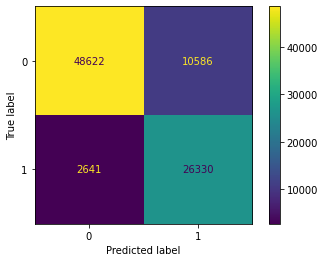

[0.60351933]


In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

logreg = LogisticRegression(C=0.01, max_iter=10000).fit(features_sub, labels) # ONLY SCORED ONES
print(logreg.score(features_sub, labels))

preds = logreg.predict(features_sub)
dp = ConfusionMatrixDisplay(confusion_matrix(labels, preds))
dp.plot()
plt.show()

print(logreg.intercept_)

In [28]:
print(logreg.coef_[0])

coefs = pd.DataFrame(
    logreg.coef_[0],
    columns=["Coefficients"],
    index=features_sub.columns.tolist(),
)

print(coefs)

[-3.18710571 -3.54820516 -0.64206444 -0.35998824 -0.36417392 -0.90479795
 -1.0944262   0.82812592 -3.69685507 -3.27990963 -1.59986437  0.31680476
 -0.06781213 -2.44338736 -0.60334415  0.16753881]
           Coefficients
164889003     -3.187106
164890007     -3.548205
164909002     -0.642064
164934002     -0.359988
251146004     -0.364174
270492004     -0.904798
284470004     -1.094426
39732003       0.828126
426177001     -3.696855
427084000     -3.279910
427393009     -1.599864
445118002      0.316805
47665007      -0.067812
59118001      -2.443387
59931005      -0.603344
713426002      0.167539


In [29]:
indexes = coefs.index

new_labels = []
for label in indexes:
    print(label, df_physionet.loc[df_physionet['SNOMEDCTCode'] == int(label), 'Dx'].values[0])
    new_tmp = df_physionet.loc[df_physionet['SNOMEDCTCode'] == int(label), 'Dx'].values[0]
    new_asd = new_tmp + ' [' + str(label) + ']'
    new_labels.append(new_asd)

print(len(new_labels))

164889003 atrial fibrillation
164890007 atrial flutter
164909002 left bundle branch block
164934002 t wave abnormal
251146004 low qrs voltages
270492004 1st degree av block
284470004 premature atrial contraction
39732003 left axis deviation
426177001 sinus bradycardia
427084000 sinus tachycardia
427393009 sinus arrhythmia
445118002 left anterior fascicular block
47665007 right axis deviation
59118001 right bundle branch block
59931005 t wave inversion
713426002 incomplete right bundle branch block
16


In [30]:
coefs.index = new_labels

<AxesSubplot:>

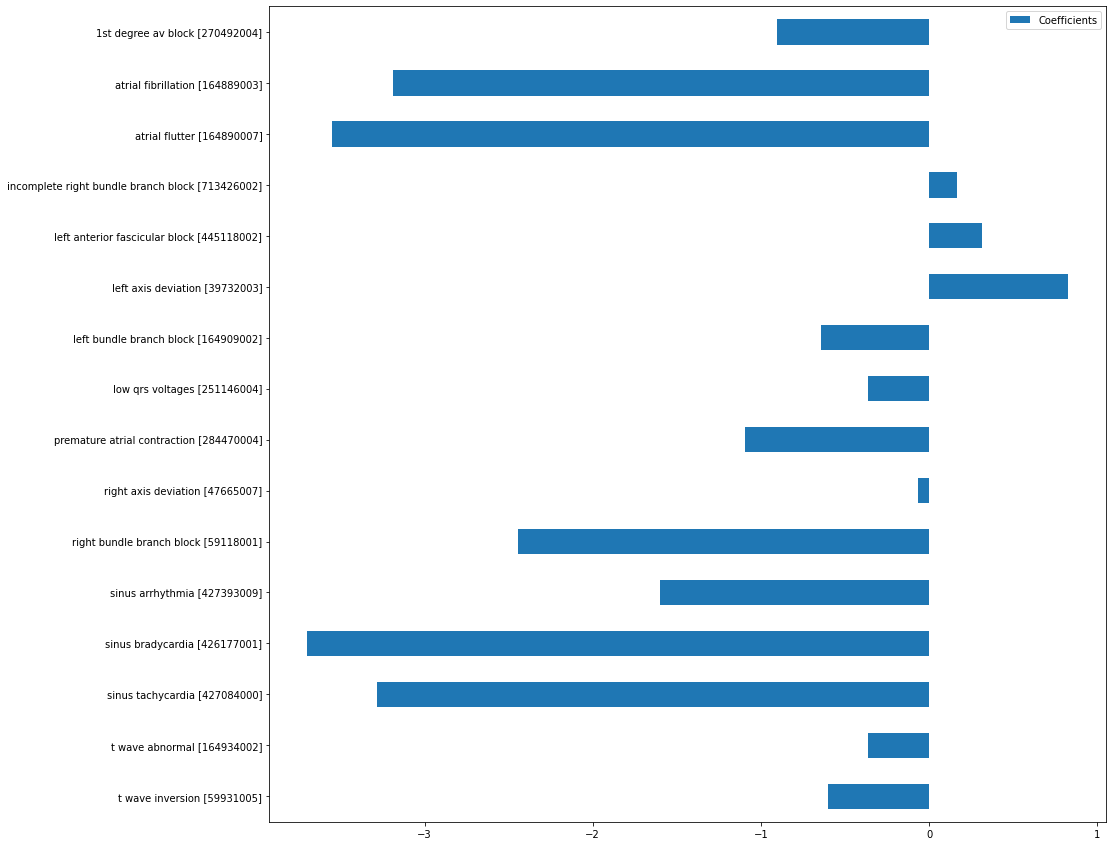

In [31]:
coefs.sort_index(ascending=False).plot(kind='barh', figsize=(15,15))

In [32]:
import statsmodels.api as sm

logit_model=sm.Logit(labels, features_sub).fit(maxiter=1000)
print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.359346
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                88179
Model:                          Logit   Df Residuals:                    88163
Method:                           MLE   Df Model:                           15
Date:                Mon, 22 May 2023   Pseudo R-squ.:                  0.4324
Time:                        13:09:40   Log-Likelihood:                -31687.
converged:                       True   LL-Null:                       -55830.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
164889003     -5.3499      0.167    -32.106      0.000      -5.676      -5.023
164890007     -6.0496      0

# <font color = teal> Predict SRs for the SPH data </font>

In [70]:
# ---- CSV FILE OF THE METADATA
csv_path = 'updated_metadata.csv'

# ---- CSV FILE OF LABEL MAPPING
map_path = 'AHA_SNOMED_mapping.csv'

# --- FROM WHICH AND TO WHICH TO CONVERT
#     corresponds to the columns from where the codes are read from metadata and mapping file
from_code = 'AHA_Code'
to_code = 'SNOMEDCTCode'

# -------------------------------------------------------------------------------

# Read the csv file containing metadata
metadata = pd.read_csv(csv_path, index_col='ECG_ID')

# Create an empty column to which to gather the SNOMED CT Codes
metadata[to_code] = np.nan

# Get label mapping
label_map = pd.read_csv(map_path, sep=',')

display(label_map)

,Dx,SNOMEDCTCode,AHA_Code
0,1st degree av block,270492004,82
1,atrial fibrillation,164889003,50
2,atrial fibrillation,164889003,50+346
3,atrial fibrillation,164889003,50+347
4,atrial flutter,164890007,51
5,incomplete right bundle branch block,713426002,105
6,left anterior fascicular block,445118002,101
7,left axis deviation,39732003,121
8,left bundle branch block,164909002,104
9,low qrs voltages,251146004,125


In [71]:
display(metadata.head())
metadata.shape

,AHA_Code,Patient_ID,Age,Sex,N,Date,SNOMEDCTCode
ECG_ID,,,,,,,
SPH00001.h5,22;23,S00001,55,M,5000,2020-03-04,NaN
SPH00002.h5,1,S00002,32,M,6000,2019-09-03,NaN
SPH00003.h5,1,S00003,63,M,6500,2020-07-16,NaN
SPH00004.h5,23,S00004,31,M,5000,2020-07-14,NaN
SPH00005.h5,146,S00005,47,M,5500,2020-01-07,NaN


(25770, 7)

In [72]:
# Doublecheck the special characters to confirm that there are no other used except ; and +
sc = []
for value in metadata['AHA_Code'].tolist():
    found = re.findall('\W+', value)
    if bool(found):
        sc.append(found)

Counter([v for value in sc for v in value])

Counter({';': 4651, '+': 2713})

In [73]:
# Get the number of each diagnosis in the Shandong data
metadata_diagnoses = metadata['AHA_Code'].copy()
metadata_diagnoses_1 = [dx for dx in metadata_diagnoses if not ';' in dx] # if not ; -> only one diagnosis
metadata_diagnoses_multiple = [dx for dx in metadata_diagnoses if ';' in dx] # If ; -> multiple diagnoses

# Flatten the array of multiple diagnoses
flatten_multiple_dx = []
for dx in metadata_diagnoses_multiple:
    dx = dx.split(';')
    for d in dx:
        flatten_multiple_dx.append(d)

print(Counter(flatten_multiple_dx))
print(Counter(metadata_diagnoses_1))
shandong_counts = Counter(flatten_multiple_dx) + Counter(metadata_diagnoses_1)

Counter({'22': 1400, '147': 929, '23': 675, '146': 558, '145+362': 504, '105': 421, '21': 340, '106': 320, '145': 302, '50': 291, '60': 252, '82': 222, '142': 186, '125': 157, '60+310': 144, '60+308': 136, '30': 134, '50+346': 127, '147+367': 104, '101': 98, '51': 93, '153': 88, '30+308': 88, '161+332': 82, '30+310': 71, '120': 59, '165+332': 57, '121': 55, '86': 47, '160+332': 43, '104': 38, '36': 35, '85': 35, '145+363': 34, '60+341': 25, '148': 23, '37': 20, '60+342': 20, '88': 18, '140': 16, '30+341': 14, '30+349': 10, '30+340': 9, '165+331': 8, '166+332': 7, '152': 7, '50+347': 6, '108': 6, '143': 6, '155': 5, '54': 5, '160': 4, '165+330': 4, '1': 4, '83': 4, '161+331': 3, '60+350': 3, '87': 3, '81': 3, '60+340': 3, '80': 2, '165': 2, '102': 2, '84': 2, '31': 2, '161+330': 2, '160+330': 1, '161': 1})
Counter({'1': 13903, '22': 1312, '147': 1115, '23': 878, '105': 838, '145+362': 520, '146': 505, '145': 468, '106': 390, '21': 385, '60': 175, '50': 169, '125': 165, '60+308': 135, '6

In [74]:
# There should be normal ECGs labeled with a label '1' and the number of it should be 13905 but found only 13903
# Why? ::
for dx in metadata_diagnoses_multiple:
    dx = dx.split(';')
    if '1' in dx:
        print(dx)

# -> Few normal ECGs have been labeled with an array of 1s

['1', '1']
['1', '1']


In [75]:
# Iterate over metadata file and add a SNOMED CT Code if possible
for index, values in metadata.iterrows():

    aha = str(values['AHA_Code'])

    # If there is +-sign in diagnosis, there are modifiers
    if '+' in aha:
        codes = aha.split(';')
    
    else:
        codes = re.findall('\d+', aha) # might be one or multiple

    # Find normal ecgs and map them with "-1"
    if '1' in codes:
        metadata.loc[index, to_code] = '-1'

    # Check if any code in metadata found from the mapping csv file
    # If yes, find corresponding SNOMED CT Codes
    if any(c for c in codes if str(c) in label_map[from_code].values):
        found_codes = [c for c in codes if str(c) in label_map[from_code].values]
    
        # Gather codes
        snomed = []
        for dx in found_codes:
            snomed.append(label_map.loc[label_map[from_code] == dx, to_code].tolist()[0])

            
        # If codes, convert into a string of codes and store using row index
        if snomed:
            metadata.loc[index, to_code] = ','.join(list(map(str, set(snomed))))
        
display(metadata.head(20))

,AHA_Code,Patient_ID,Age,Sex,N,Date,SNOMEDCTCode
ECG_ID,,,,,,,
SPH00001.h5,22;23,S00001,55,M,5000,2020-03-04,"426177001,427393009"
SPH00002.h5,1,S00002,32,M,6000,2019-09-03,-1
SPH00003.h5,1,S00003,63,M,6500,2020-07-16,-1
SPH00004.h5,23,S00004,31,M,5000,2020-07-14,427393009
SPH00005.h5,146,S00005,47,M,5500,2020-01-07,NaN
SPH00006.h5,1,S00006,46,F,5000,2019-08-31,-1
SPH00007.h5,106,S00007,75,M,6500,2020-04-01,59118001
SPH00008.h5,1,S00008,32,M,5000,2019-10-02,-1
SPH00009.h5,1,S00009,48,F,6000,2019-08-20,-1


In [76]:
print(metadata.shape)
print(metadata.info() )
# null values in SNOMEDCTCode column -> drop those rows as they can't be used with fitted Logistic regression

metadata = metadata.dropna()
metadata

(25770, 7)
<class 'pandas.core.frame.DataFrame'>
Index: 25770 entries, SPH00001.h5 to SPH25770.h5
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   AHA_Code      25770 non-null  object
 1   Patient_ID    25770 non-null  object
 2   Age           25770 non-null  int64 
 3   Sex           25770 non-null  object
 4   N             25770 non-null  int64 
 5   Date          25770 non-null  object
 6   SNOMEDCTCode  23274 non-null  object
dtypes: int64(2), object(5)
memory usage: 2.6+ MB
None


,AHA_Code,Patient_ID,Age,Sex,N,Date,SNOMEDCTCode
ECG_ID,,,,,,,
SPH00001.h5,22;23,S00001,55,M,5000,2020-03-04,"426177001,427393009"
SPH00002.h5,1,S00002,32,M,6000,2019-09-03,-1
SPH00003.h5,1,S00003,63,M,6500,2020-07-16,-1
SPH00004.h5,23,S00004,31,M,5000,2020-07-14,427393009
SPH00006.h5,1,S00006,46,F,5000,2019-08-31,-1
...,...,...,...,...,...,...,...
SPH25765.h5,1,S24661,52,F,5000,2019-08-26,-1
SPH25767.h5,23,S24663,37,F,5000,2020-03-01,427393009
SPH25768.h5,147,S24664,56,F,5000,2020-06-07,164934002


In [77]:
# How many rows missing compared to the original dataset after dropping those null value rows?
25770 - metadata.shape[0]

2496

In [78]:
# Create feature matrix to which map all diagnosed labels based on SNOMED CT Codes

feature_labels = list(features_sub.columns) # use the order of the label columns of the feature_sub dataframe

f_matrix =  np.array([[0]*len(feature_labels)] * metadata.shape[0]) # matrix size <num of ecgs left in shandong> X <labels>
assert len(f_matrix) == metadata.shape[0] # check number of rows
assert len(f_matrix[0]) == len(feature_labels) # check number of cols

for i, dx in enumerate(metadata['SNOMEDCTCode']):
    
    # If diagnos is "normal ecg", no need to do anything (i.e. no abnormalities diagnosed)
    if str(dx) == '-1':
        continue
    else:
        codes = re.findall('\d+', dx)

        # More than one diagnosis
        if len(codes) > 1:
            for d in codes:
                d_index = feature_labels.index(d)
                f_matrix[i][d_index] = 1
        else:
            d_index = feature_labels.index(codes[0])
            f_matrix[i][d_index] = 1

In [79]:
sph_feature_map = pd.DataFrame(f_matrix, columns=feature_labels)
sph_feature_map

,164889003,164890007,164909002,164934002,251146004,270492004,284470004,39732003,426177001,427084000,427393009,445118002,47665007,59118001,59931005,713426002
0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23269,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
23270,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
23271,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
23272,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0


In [80]:
# Predict the SR label
sr_predictions = logreg.predict(sph_feature_map)
len(sr_predictions)

23274

In [81]:
metadata['SR'] = sr_predictions

In [82]:
# == Check which diagnoses have been labeled with SR and which ones are not

preds_df = pd.DataFrame(columns=['Diagnosis', 'SNOMEDCTCode', 'SR', 'not SR', 'Total count', 'SR Ratio'])
preds_df['Diagnosis'] = dx_names
preds_df['SNOMEDCTCode'] = dx_labels

# == SR not labeled ==

no_sr = metadata.loc[metadata['SR'] == 0]
metadata_diagnoses_1 =  [dx for dx in no_sr['SNOMEDCTCode'] if not ',' in dx]
metadata_diagnoses_multiple = [dx for dx in no_sr['SNOMEDCTCode'] if ',' in dx]


flatten_multiple_dx = []
for dx in metadata_diagnoses_multiple:
    dx = dx.split(',')
    for d in dx:
        flatten_multiple_dx.append(d)

all_dx = Counter(flatten_multiple_dx) + Counter(metadata_diagnoses_1)
for l, c in all_dx.most_common():
    if int(l) in dx_labels:
        print(l, c)

for label, count in all_dx.most_common():
    preds_df.loc[preds_df['SNOMEDCTCode'] == int(label), 'not SR'] = count

# ===============

print('---'*10)
 
# == SR labeled ==

yes_sr = metadata.loc[metadata['SR'] == 1]
metadata_diagnoses_1 = [dx for dx in yes_sr['SNOMEDCTCode'] if not ',' in dx]
metadata_diagnoses_multiple = [dx for dx in yes_sr['SNOMEDCTCode'] if ',' in dx]


flatten_multiple_dx = []
for dx in metadata_diagnoses_multiple:
    dx = dx.split(',')
    for d in dx:
        flatten_multiple_dx.append(d)

all_dx = Counter(flatten_multiple_dx) + Counter(metadata_diagnoses_1)
for l, c in all_dx.most_common():
    if int(l) in dx_labels:
        print(l, c)

for label, count in all_dx.most_common():
    preds_df.loc[preds_df['SNOMEDCTCode'] == int(label), 'SR'] = count


426177001 2711
427393009 1553
427084000 725
59118001 710
164934002 701
164889003 675
284470004 538
713426002 289
270492004 231
251146004 125
164890007 99
164909002 84
445118002 65
59931005 58
47665007 40
39732003 21
------------------------------
164934002 1341
713426002 970
251146004 197
47665007 121
59931005 118
39732003 117
445118002 89
270492004 7
284470004 1


In [83]:
afib = []
pac = []
for label, count in shandong_counts.most_common():

    if label in label_map['AHA_Code'].values:

        # Handle afib and modifiers
        if '50' in str(label):
            if not '347' in str(label):
                afib.append(count)
                continue
            else:
                count = sum(afib) + count
                label = '50'

        # Handle premature atrial contraction and modifiers
        if '30' in str(label):
            if not '340' in str(label):
                pac.append(count)
                continue
            else:
                count = sum(pac) + count
                label = '30'
    
        as_english = label_map.loc[label_map['AHA_Code'] == label, 'Dx'].values[0]
        as_snomed = label_map.loc[label_map['AHA_Code'] == label, 'SNOMEDCTCode'].values[0]
        preds_df.loc[preds_df['SNOMEDCTCode'] == int(as_snomed), 'Total count'] = count

        print('{:>40} [{:^11}] {:^10} {:>5}'.format(as_english, as_snomed, label, count))

                       sinus bradycardia [ 426177001 ]     22      2712
                         t wave abnormal [ 164934002 ]    147      2044
                        sinus arrhythmia [ 427393009 ]     23      1553
    incomplete right bundle branch block [ 713426002 ]    105      1259
                       sinus tachycardia [ 427084000 ]     21       725
               right bundle branch block [ 59118001  ]    106       710
                        low qrs voltages [ 251146004 ]    125       322
                     1st degree av block [ 270492004 ]     82       238
                        t wave inversion [ 59931005  ]  147+367     176
                    right axis deviation [ 47665007  ]    120       161
          left anterior fascicular block [ 445118002 ]    101       154
                     left axis deviation [ 39732003  ]    121       138
                          atrial flutter [ 164890007 ]     51        99
                left bundle branch block [ 164909002 ]    104   

In [84]:
preds_df['SR'] = preds_df['SR'].replace(np.nan, 0)

In [85]:
for index, values in preds_df.iterrows():
    sr_count = values['SR']
    total_count = values['Total count']
    preds_df.loc[index, 'SR Ratio'] = round(sr_count / total_count, 3)

In [86]:
preds_df

,Diagnosis,SNOMEDCTCode,SR,not SR,Total count,SR Ratio
0,sinus bradycardia,426177001,0,2711,2712,0.0
1,t wave abnormal,164934002,1341,701,2044,0.656
2,sinus arrhythmia,427393009,0,1553,1553,0.0
3,incomplete right bundle branch block,713426002,970,289,1259,0.77
4,sinus tachycardia,427084000,0,725,725,0.0
5,right bundle branch block,59118001,0,710,710,0.0
6,atrial fibrillation,164889003,0,675,676,0.0
7,t wave inversion,59931005,118,58,176,0.67
8,right axis deviation,47665007,121,40,161,0.752
9,left anterior fascicular block,445118002,89,65,154,0.578


# <font color = teal> Merge SR analysis and SR prediction results </font>

In [87]:
# Rename the columns for better interpretation
preds_df = preds_df.rename(columns={'SR Ratio': 'Shandong Ratio', 'SR': 'Shandong SR', 'not SR':'Shandong not SR', 'Total count': 'Shandong Total'})
scored_df = scored_df.rename(columns={'Dx': 'Diagnosis', 'Ratio': 'Physio Ratio', 'Count_SR': 'Physio SR', 'Count_total': 'Physio Total'})

# Compute "not SR" for physionet data
scored_df['Physio not SR'] = scored_df['Physio Total'] - scored_df['Physio SR']

# Reorder columns
scored_df = scored_df[['Diagnosis', 'SNOMEDCTCode', 'Physio SR', 'Physio not SR', 'Physio Total', 'Physio Ratio']]

# Merge using the SNOMEDCTCode column
merged_df = pd.merge(scored_df, preds_df, on="SNOMEDCTCode")
merged_df = merged_df.drop(columns=['Diagnosis_y'])
merged_df

,Diagnosis_x,SNOMEDCTCode,Physio SR,Physio not SR,Physio Total,Physio Ratio,Shandong SR,Shandong not SR,Shandong Total,Shandong Ratio
0,left axis deviation,39732003,4205,3426,7631,0.551,117,21,138,0.848
1,t wave abnormal,164934002,2495,9221,11716,0.213,1341,701,2044,0.656
2,left anterior fascicular block,445118002,1275,911,2186,0.583,89,65,154,0.578
3,1st degree av block,270492004,938,2596,3534,0.265,7,231,238,0.029
4,incomplete right bundle branch block,713426002,884,973,1857,0.476,970,289,1259,0.77
5,sinus arrhythmia,427393009,636,3154,3790,0.168,0,1553,1553,0.0
6,premature atrial contraction,284470004,502,2539,3041,0.165,1,538,556,0.002
7,t wave inversion,59931005,491,3498,3989,0.123,118,58,176,0.67
8,left bundle branch block,164909002,386,895,1281,0.301,0,84,84,0.0
9,sinus bradycardia,426177001,359,18559,18918,0.019,0,2711,2712,0.0


In [88]:
def highlight_col(x):
    r = 'background-color: red'
    df1 = pd.DataFrame('', index=x.index, columns=x.columns)
    df1.iloc[:, 0] = r
    return df1    

merged_df.style.set_properties(**{'background-color': 'green', 'opacity': 0.5}, subset=['Physio Ratio', 'Shandong Ratio'])

,Diagnosis_x,SNOMEDCTCode,Physio SR,Physio not SR,Physio Total,Physio Ratio,Shandong SR,Shandong not SR,Shandong Total,Shandong Ratio
0,left axis deviation,39732003,4205,3426,7631,0.551000,117,21,138,0.848000
1,t wave abnormal,164934002,2495,9221,11716,0.213000,1341,701,2044,0.656000
2,left anterior fascicular block,445118002,1275,911,2186,0.583000,89,65,154,0.578000
3,1st degree av block,270492004,938,2596,3534,0.265000,7,231,238,0.029000
4,incomplete right bundle branch block,713426002,884,973,1857,0.476000,970,289,1259,0.770000
5,sinus arrhythmia,427393009,636,3154,3790,0.168000,0,1553,1553,0.000000
6,premature atrial contraction,284470004,502,2539,3041,0.165000,1,538,556,0.002000
7,t wave inversion,59931005,491,3498,3989,0.123000,118,58,176,0.670000
8,left bundle branch block,164909002,386,895,1281,0.301000,0,84,84,0.000000
9,sinus bradycardia,426177001,359,18559,18918,0.019000,0,2711,2712,0.000000


<AxesSubplot:>

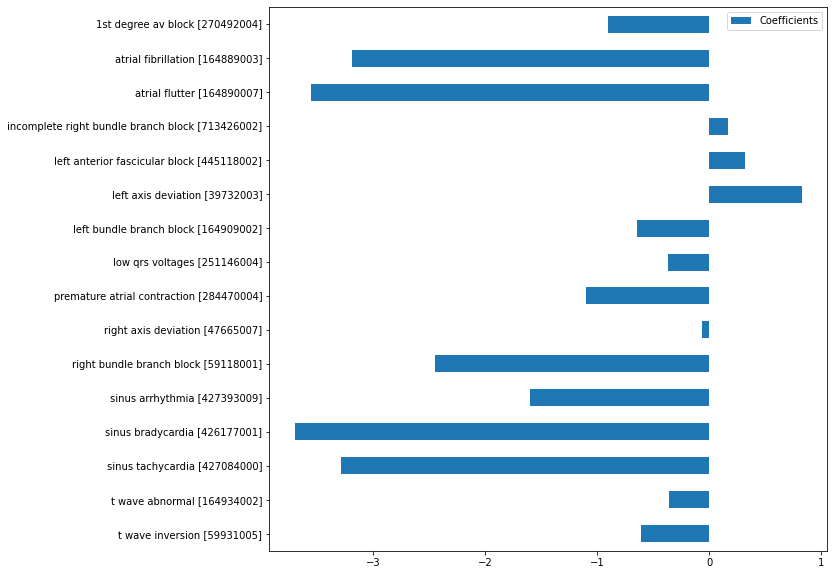

In [89]:
coefs.sort_index(ascending=False).plot(kind='barh', figsize=(10,10))

In [90]:
metadata

,AHA_Code,Patient_ID,Age,Sex,N,Date,SNOMEDCTCode,SR
ECG_ID,,,,,,,,
SPH00001.h5,22;23,S00001,55,M,5000,2020-03-04,"426177001,427393009",0
SPH00002.h5,1,S00002,32,M,6000,2019-09-03,-1,1
SPH00003.h5,1,S00003,63,M,6500,2020-07-16,-1,1
SPH00004.h5,23,S00004,31,M,5000,2020-07-14,427393009,0
SPH00006.h5,1,S00006,46,F,5000,2019-08-31,-1,1
...,...,...,...,...,...,...,...,...
SPH25765.h5,1,S24661,52,F,5000,2019-08-26,-1,1
SPH25767.h5,23,S24663,37,F,5000,2020-03-01,427393009,0
SPH25768.h5,147,S24664,56,F,5000,2020-06-07,164934002,1


# <font color = teal> Convert predicted SR labels into the SNOMED CT Code of Sinus Rhythm </font>

In [91]:
display(metadata.head(10))

# No need to do anything with the SR==0 predictions, 
# so just add 426783006 to all SNOMEDCTCode columns where SR column is 1

sinus_rhythm = 426783006

for index, values in metadata.iterrows():

    snomeds = str(values['SNOMEDCTCode'])
    
    if snomeds == '-1': # map normal ecgs
        metadata.loc[index, 'SNOMEDCTCode'] = sinus_rhythm
        
    else: # map everything else
        snomeds = snomeds + ',' + str(sinus_rhythm)
        metadata.loc[index, 'SNOMEDCTCode'] = snomeds

display(metadata.head())

,AHA_Code,Patient_ID,Age,Sex,N,Date,SNOMEDCTCode,SR
ECG_ID,,,,,,,,
SPH00001.h5,22;23,S00001,55,M,5000,2020-03-04,"426177001,427393009",0
SPH00002.h5,1,S00002,32,M,6000,2019-09-03,-1,1
SPH00003.h5,1,S00003,63,M,6500,2020-07-16,-1,1
SPH00004.h5,23,S00004,31,M,5000,2020-07-14,427393009,0
SPH00006.h5,1,S00006,46,F,5000,2019-08-31,-1,1
SPH00007.h5,106,S00007,75,M,6500,2020-04-01,59118001,0
SPH00008.h5,1,S00008,32,M,5000,2019-10-02,-1,1
SPH00009.h5,1,S00009,48,F,6000,2019-08-20,-1,1
SPH00010.h5,1,S00010,32,F,7500,2020-06-29,-1,1


,AHA_Code,Patient_ID,Age,Sex,N,Date,SNOMEDCTCode,SR
ECG_ID,,,,,,,,
SPH00001.h5,22;23,S00001,55,M,5000,2020-03-04,"426177001,427393009,426783006",0
SPH00002.h5,1,S00002,32,M,6000,2019-09-03,426783006,1
SPH00003.h5,1,S00003,63,M,6500,2020-07-16,426783006,1
SPH00004.h5,23,S00004,31,M,5000,2020-07-14,"427393009,426783006",0
SPH00006.h5,1,S00006,46,F,5000,2019-08-31,426783006,1


In [93]:
# Save the updated metadata with predicted SR labels
metadata.to_csv('metadata_sr.csv', index=True)